In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# Process accented characters
import unicodedata

# NLTK
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# Machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Import different metrics to evaluate the classifiers
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

from sklearn.utils import resample

#import time function from time module to track the training duration
from time import time

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Connect to database

In [2]:
# SQL Alchemy
from sqlalchemy import create_engine

In [3]:
# Create engine and connection
engine = create_engine("sqlite:///../db.sqlite")

In [4]:
# Check for tables
engine.table_names()

['cuisine_ingredients']

In [5]:
# Read in the csv file
df = pd.read_sql_query('SELECT * FROM cuisine_ingredients', con=engine)

In [6]:
# Overview of the data set
df.sample(10, random_state=2)

,id,cuisine,recipe,full_ingredients
3727,3728,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ..."
1923,1924,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie..."
3552,3553,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri..."
1146,1147,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1..."
3195,3196,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e..."
1643,1644,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in..."
3054,3055,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small..."
842,843,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz..."
505,506,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a..."
2224,2225,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int..."


In [7]:
# Get a list of unique cuisines in the dataset
cuisine_list = df.cuisine.unique().tolist()
cuisine_list

['African',
 'American',
 'British',
 'Caribbean',
 'Chinese',
 'East European',
 'French',
 'Greek',
 'Indian',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Mexican',
 'Nordic',
 'North African',
 'Pakistani',
 'Portuguese',
 'South American',
 'Spanish',
 'Thai and South-East Asian',
 'Turkish and Middle Eastern']

## Define text pre-processing function

In [8]:
# Create a function to remove accented characters
def remove_accented_chars(matchobj):
    text = matchobj.group()
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

I'm combining the text cleaning and pre-processing steps as explored and explained in the 00_EDA file.

In [9]:
# Create a function to clean ingredient text
def clean(doc):
    doc = doc.str.lower()
    doc = doc.str.replace(r'\w*[\d¼½¾⅓⅔⅛⅜⅝]\w*', '')
    doc = doc.str.translate(str.maketrans('', '', string.punctuation))
    doc = doc.str.replace(r'[£×–‘’“”⁄]', '')
#     doc = doc.apply(lambda x: re.sub(r'[âãäçèéêîïñóôûüōưấớ]', remove_accented_chars, x))
    doc = doc.apply(lambda x: word_tokenize(x))
    doc = doc.apply(lambda x: [word for word in x if not word in stop_words_nltk])
    doc = doc.apply(lambda x: [stemmer.stem(word) for word in x])
    processed_doc = doc.apply(lambda x: ' '.join([word for word in x]))

    return processed_doc

In [10]:
# Add a new column to the dataframe with the cleaned text
df["ingredients_processed"] = clean(df.full_ingredients)

In [11]:
# Overview of the dataset
df.sample(10, random_state=2)

,id,cuisine,recipe,full_ingredients,ingredients_processed
3727,3728,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ...",oliv oil shallow deep fri shallot fine chop ga...
1923,1924,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie...",tbsp groundnut oil long dri chilli tsp sichuan...
3552,3553,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri...",tbsp sunflow oil rasher thick rindless smoke s...
1146,1147,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1...",butter jumbo oat roll oat red onion roughli ch...
3195,3196,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e...",flour medium freerang egg prefer bright yellow...
1643,1644,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in...",flouri potato peel cut cube rasher smoke strea...
3054,3055,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small...",oz greekstyl yoghurt small onion roughli chop ...
842,843,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz...",dri yellow split pea butter onion roughli chop...
505,506,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a...",beef shin bone sea salt freshli ground black p...
2224,2225,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int...",celeriac peel slice thin matchstick see tip le...


## Modeling

### Split the data into training and test sets (75% train and 25% test)

In [12]:
# The column contains textual data to extract features from.
X = df.ingredients_processed

# The column we're learning to predict.
y = df.cuisine
print(X.shape, y.shape)

(4724,) (4724,)


In [13]:
# Split X and y into training and testing sets. By default, it splits 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3543,) (3543,)
(1181,) (1181,)


### Resampling

In [14]:
# Concatenate our training data back together
X_y_train = pd.concat([X_train, y_train], axis=1)
X_y_train.shape

(3543, 2)

In [15]:
# Overview of the training set
X_y_train.head()

,ingredients_processed,cuisine
1948,fresh white fish fillet sole plaic cornflour d...,Chinese
921,tbsp oliv oil goodqual pork sausag shallot fin...,British
4215,tbsp veget oil onion fine chop garlic clove fi...,Pakistani
2601,x sirloin steak salt freshli ground black pepp...,French
3770,type pasta flour avail supermarket bake sectio...,Italian


In [16]:
# Separate minority and majority classes
british_cuisines_df = X_y_train[X_y_train.cuisine=="British"]
other_cuisines_df = X_y_train[X_y_train.cuisine!="British"]
other_cuisines_df.head()

,ingredients_processed,cuisine
1948,fresh white fish fillet sole plaic cornflour d...,Chinese
4215,tbsp veget oil onion fine chop garlic clove fi...,Pakistani
2601,x sirloin steak salt freshli ground black pepp...,French
3770,type pasta flour avail supermarket bake sectio...,Italian
3737,tagliatel broccoli cut small floret hand pea f...,Italian


In [17]:
# Get a list of minority cuisines
other_cuisines = other_cuisines_df.cuisine.unique().tolist()
other_cuisines

['Chinese',
 'Pakistani',
 'French',
 'Italian',
 'Japanese',
 'Indian',
 'Mexican',
 'American',
 'Nordic',
 'Turkish and Middle Eastern',
 'Caribbean',
 'Thai and South-East Asian',
 'North African',
 'East European',
 'Irish',
 'Portuguese',
 'Greek',
 'South American',
 'Spanish',
 'Korean',
 'African']

In [18]:
other_cuisines_upsampled = list()

# Upsample the minorities

for cuisine in other_cuisines:
    cuisine_df = X_y_train[X_y_train.cuisine==cuisine]
    cuisine_upsampled = resample(cuisine_df,
                                 replace=True, # sample with replacement
                                 n_samples=len(british_cuisines_df), # match number of recipes in British cuisine
                                 random_state=1)
    other_cuisines_upsampled.append(cuisine_upsampled)

In [19]:
# Create a new resampled data set for minority cuisines
other_cuisines_upsampled = pd.concat(other_cuisines_upsampled)
other_cuisines_upsampled.head()

,ingredients_processed,cuisine
1909,tbsp veget oil plu extra shallow fri firm tofu...,Chinese
2041,firm white fish fillet cod sole skin whole fis...,Chinese
2019,tbsp shaox rice wine dri sherri tbsp light soy...,Chinese
1980,x lobster tsp sesam oil fresh root ginger peel...,Chinese
1999,pork minc ginger grate garlic grate spring oni...,Chinese


In [20]:
# Combine the majority and the upsampled minority
upsampled = pd.concat([british_cuisines_df, other_cuisines_upsampled])

In [21]:
# check new class counts
upsampled.cuisine.value_counts()

Turkish and Middle Eastern    1098
Mexican                       1098
Italian                       1098
American                      1098
Chinese                       1098
East European                 1098
Spanish                       1098
Japanese                      1098
North African                 1098
French                        1098
Thai and South-East Asian     1098
Irish                         1098
British                       1098
South American                1098
Pakistani                     1098
African                       1098
Greek                         1098
Nordic                        1098
Portuguese                    1098
Caribbean                     1098
Indian                        1098
Korean                        1098
Name: cuisine, dtype: int64

In [22]:
# Overview of the upsampled dataset
upsampled.sample(10, random_state=2)

,ingredients_processed,cuisine
4133,oliv oil fri larg chicken thigh onion fine cho...,North African
3773,flour freerang italian yellow golden egg durum...,Italian
2592,salt butter room temperatur caster sugar star ...,French
4159,small chicken joint piec tbsp oliv oil preserv...,North African
4204,tbsp ghee clarifi butter onion fine chop fresh...,Pakistani
3943,fillet beef garlic clove fresh root ginger sli...,Korean
4287,whole king prawn around medium oz oliv oil gar...,Spanish
4046,tbsp oliv oil plu extra greas beef minc red on...,Mexican
2145,salmon fillet skin longgrain rice butter plu e...,East European
4413,duck breast skin oz veget oil oz dark soy sauc...,Thai and South-East Asian


### Feature engineering using TF-IDF

In bags of words and bags of n-grams approaches, all words in a corpus are treated equally important. TF-IDF, meanwhile, emphasizes that some words in a document are more important than others. For the current classification problem, I find that TF-IDF would suit the best.

In [23]:
tfidf = TfidfVectorizer()

In [24]:
X_train_new = upsampled.ingredients_processed
y_train_new = upsampled.cuisine

In [25]:
# Vectorize train and test data
X_train_transformed = tfidf.fit_transform(X_train_new)
X_test_transformed = tfidf.transform(X_test)
print(X_train_transformed.shape, X_test_transformed.shape)

(24156, 2911) (1181, 2911)


### Train the model

In [26]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')

In [27]:
# Train the classifier and time the training step
%time model.fit(X_train_transformed, y_train_new)

Wall time: 27.1 s


SVC(kernel='linear')

In [28]:
# Make class predictions for X_test_transformed
y_predicted = model.predict(X_test_transformed)
y_predicted

array(['Italian', 'French', 'British', ..., 'American', 'British',
       'Italian'], dtype=object)

 ### Evaluate the model using accuracy, confusion matrix, and classification report

In [29]:
# Use a Dummy Classifer to classify cuisines without even training a "real" model
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier().fit(X_train_transformed, y_train_new)
dummy_pred = dummy.predict(X_test_transformed)

# Check accuracy on test set
print('Dummy Classifer Test Accuracy: ', accuracy_score(y_test, dummy_pred))

Dummy Classifer Test Accuracy:  0.03217612193056731


C:\Users\Boss\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [30]:
# Print accuracy on test set:
print("Test Accuracy: ", accuracy_score(y_test, y_predicted))

Test Accuracy:  0.6943268416596104


In [31]:
# Print accuracy on train set:
print("Train Accuracy: ", model.score(X_train_transformed, y_train_new))

Train Accuracy:  0.9885742672627919


> Accuracy is not the best metric to evaluate imbalanced testing datasets as it can be very misleading. I'll use confusion matrix and classification report for further understanding about the model performance.

In [32]:
# Function to plot confusion matrix. 
# Ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

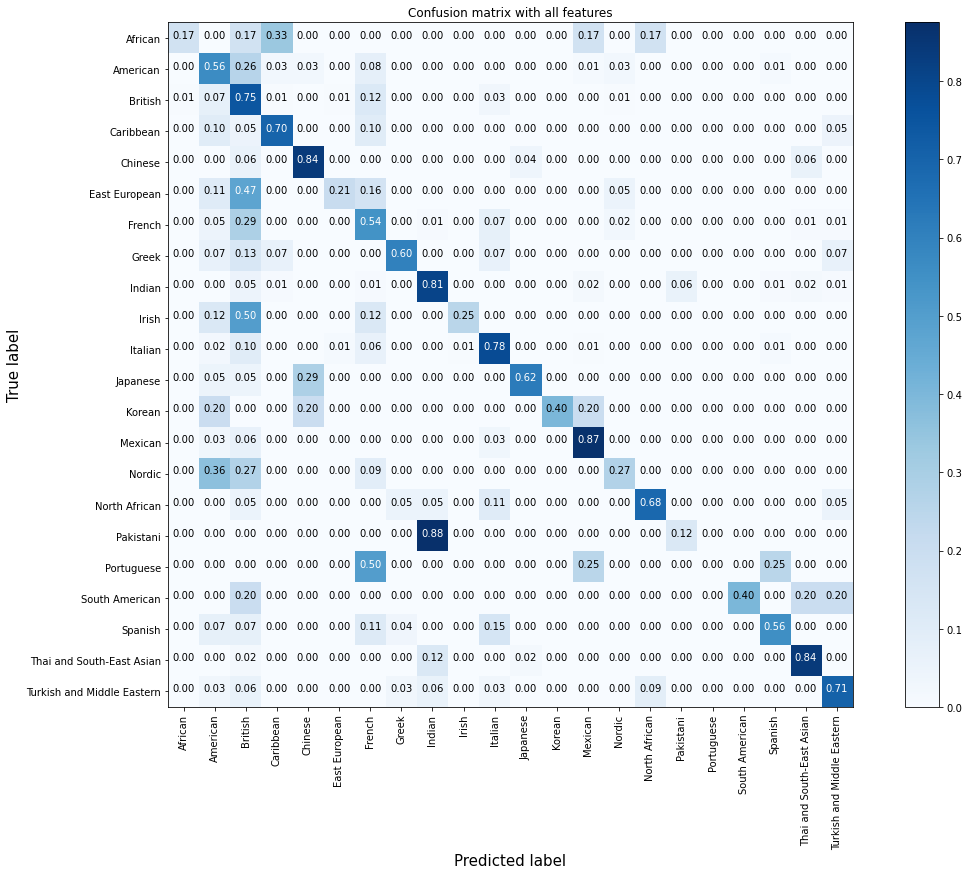

In [33]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(16, 12))
plot_confusion_matrix(cnf_matrix, classes=cuisine_list, normalize=True,
                      title='Confusion matrix with all features')

At this point, we can notice that the classifier is doing poorly with identifying xxx, while it is doing well with xxx.

In [34]:
# Calculate classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted,
                            target_names=cuisine_list))

                            precision    recall  f1-score   support

                   African       0.33      0.17      0.22         6
                  American       0.45      0.56      0.50        78
                   British       0.71      0.75      0.73       366
                 Caribbean       0.64      0.70      0.67        20
                   Chinese       0.82      0.84      0.83        50
             East European       0.50      0.21      0.30        19
                    French       0.47      0.54      0.50       122
                     Greek       0.75      0.60      0.67        15
                    Indian       0.81      0.81      0.81        98
                     Irish       0.50      0.25      0.33         8
                   Italian       0.83      0.78      0.80       178
                  Japanese       0.81      0.62      0.70        21
                    Korean       1.00      0.40      0.57         5
                   Mexican       0.79      0.87

C:\Users\Boss\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! So, what to choose as the best among these depends on what we are looking for in our usecase!

### Evaluate the model using k-fold cross validation

In [35]:
# The column contains textual data to extract features from.
X = df.ingredients_processed
X_transformed = tfidf.fit_transform(X)

# The column we're learning to predict.
y = df.cuisine 
print(X.shape, y.shape)

(4724,) (4724,)


In [36]:
# Create 10 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [37]:
# Train and evaluate multiple models using kfolds
results = cross_val_score(model, X_transformed, y, cv=kfold)
print(results)
print("Accuracy Score Mean:", results.mean())
print("Accuracy Score Std:", results.std())

[0.68710359 0.70824524 0.69133192 0.68287526 0.66525424 0.69915254
 0.71186441 0.70974576 0.66737288 0.72033898]
Accuracy Score Mean: 0.6943284838929301
Accuracy Score Std: 0.017896831675206625


### Hyperparameter Tuning

Use GridSearchCV to tune the model's parameters

In [38]:
# # Create the GridSearch estimator along with a parameter object containing the values to adjust
# from sklearn.model_selection import GridSearchCV
# param_grid = {'kernel': ["linear", "poly", "rbf", "sigmoid"]}
# grid = GridSearchCV(model, param_grid, verbose=3)

In [39]:
# Train the model with GridSearch

In [40]:
# print(grid2.best_params_)
# print(grid2.best_score_)